In [17]:
import sys
sys.path.append('../run_analyses/')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from scipy.optimize import root

from support.charting import primaryColors, fullColors, save_fig
from support.load     import loadAllData, methodParams
from support.util     import titles, order, methodTitle, modelTitle

from modelConfig      import models
from util.util        import getLeverNames

from ema_workbench.analysis import parcoords

from IPython.core import display as ICD

In [2]:
data = loadAllData()
sns.set_style('white')

--------------------------------
Loading MOEA intertemporal
Loading archives from ../data_rand/mordm/optimize/archives_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading convergences from ../data_rand/mordm/optimize/convergences_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading Pareto for intertemporal
Loading pareto from ../data_rand/mordm/optimize/nondominated_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading Robustness Summary intertemporal
Loading Robust Summary from ../data_rand/mordm/robustness/summary_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
--------------------------------
Loading MOEA plannedadaptive
Loading archives from ../data_rand/mordm/optimize/archives_plannedadaptive_NSGAIIHybrid_runs50_nfe100000_scenarios10000_refScenario-1.csv
Loading convergences from ../data_rand/mordm/optimize/convergences_plannedadaptive_NSGAIIHybrid_runs50_nf

# Separate Pareto Results

### DPS, t=1

In [3]:
def show_paracord(method='', model='', nondominated=[], outputs=['max_P','utility','inertia','reliability'], outTitles=[]):
    maxp = 0
    utility = 0
    outdatas = []
    for idx, nond in enumerate(nondominated):
        if nond['max_P'].max() > maxp: 
            maxp = nond['max_P'].max()
        if nond['utility'].max() > utility: 
            utility = nond['utility'].max()
        
        outdata = nond[outputs]
        outdata.columns = outTitles
        outdatas.append(outdata)
    
    limits = parcoords.get_limits(outdatas[0])
    limits.loc[:, [outTitles[outputs.index('inertia')], outTitles[outputs.index('reliability')]]] = [[0,0], [1,1]]
    limits.loc[:, [outTitles[outputs.index('max_P')], outTitles[outputs.index('utility')]]] = [[0,0],[9.53, 1.77]]
    
    colors = fullColors[model][method] if len(nondominated) > 1 else [primaryColors[model][method]]
    axes = parcoords.ParallelAxes(limits, rot=0, fontsize=12)
    for idx, nond in enumerate(outdatas):
        axes.plot(nond, color=colors[idx], linewidth=0.5)

    axes.invert_axis(outTitles[outputs.index('max_P')])
    
    plt.suptitle(methodTitle[method], fontsize=14,weight='bold',y=1.03)
    axes.fig.set_size_inches([5,2.5])
    save_fig(plt, 'images/outcomes/', 'parallelnondominated' + method + '_' + model)
    plt.show()

from methodFuncs.moro import robustnessFunctions
def show_paracord_moro(method='', model='', nondominated=[], outputs=['max_P','utility','inertia','reliability'], outTitles=[]):
    outdatas = []
    for idx, nond in enumerate(nondominated):
        outdata = nond[outputs]
        outdata.columns = outTitles
        outdatas.append(outdata)
        
    limits = parcoords.get_limits(outdatas[0])
    limits.iloc[0] = 0
    limits.iloc[1] = 1

    colors = fullColors[model][method] if len(nondominated) > 1 else [primaryColors[model][method]]
    axes = parcoords.ParallelAxes(limits, rot=0, fontsize=12)
    for idx, nond in enumerate(nondominated):
        outdata = nond[outputs]
        outdata.columns = outTitles
        axes.plot(outdata, color=colors[idx], linewidth=0.5)
        
    plt.suptitle(methodTitle[method], fontsize=14,weight='bold',y=1.03)
    axes.fig.set_size_inches([5,2.5])
    save_fig(plt, 'images/outcomes/', 'parallelnondominated' + method + '_' + model)
    plt.show()
    return axes

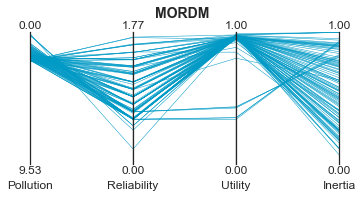

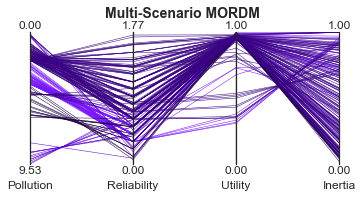

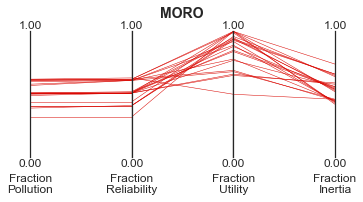

In [4]:
key = 'dps'
show_paracord(model=key, method='mordm', nondominated=data['mordm']['nondominated'][key], outTitles=titles('outcome'))
show_paracord(model=key, method='multi', nondominated=data['multi']['nondominated'][key], outTitles=titles('outcome'))
show_paracord_moro(model=key, method='moro', nondominated=data['moro']['nondominated'][key], 
                   outputs=[func.name for func in robustnessFunctions], outTitles=['Fraction\n' + name for name in titles('outcome')])

### Planned Adaptive DPS, t=10

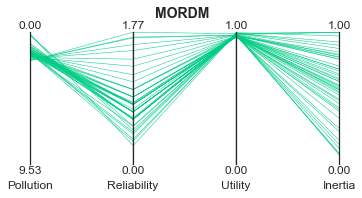

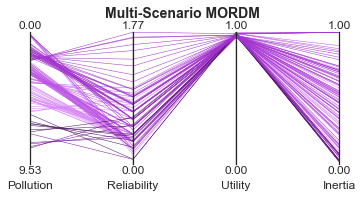

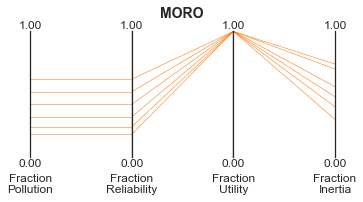

In [5]:
key = 'plannedadaptive'
show_paracord(model=key, method='mordm', nondominated=data['mordm']['nondominated'][key], outTitles=titles('outcome'))
show_paracord(model=key, method='multi', nondominated=data['multi']['nondominated'][key], outTitles=titles('outcome'))
show_paracord_moro(model=key, method='moro', nondominated=data['moro']['nondominated'][key], 
                   outputs=[func.name for func in robustnessFunctions], outTitles=['Fraction\n' + name for name in titles('outcome')])

### Intertemporal

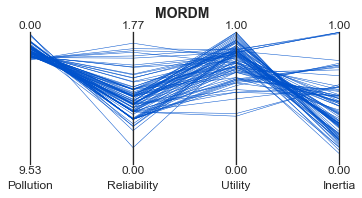

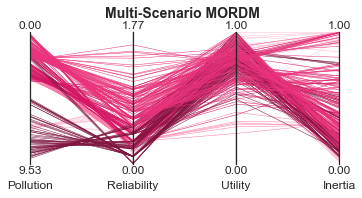

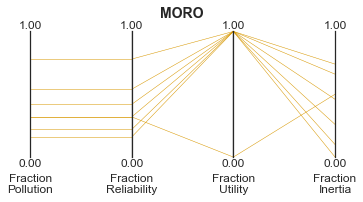

In [6]:
key = 'intertemporal'
show_paracord(model=key, method='mordm', nondominated=data['mordm']['nondominated'][key], outTitles=titles('outcome'))
show_paracord(model=key, method='multi', nondominated=data['multi']['nondominated'][key], outTitles=titles('outcome'))
show_paracord_moro(model=key, method='moro', nondominated=data['moro']['nondominated'][key], 
                   outputs=[func.name for func in robustnessFunctions], outTitles=['Fraction\n' + name for name in titles('outcome')])

# Lever Ranges

### DPS, t=1

In [56]:
def showLeverRanges(model, nondominated):
    levers = getLeverNames(models[model])
    leverVals = []
    for method in order('method'):
        nond = nondominated[method]
        if not isinstance(nond, list):
            nond=[nond]
        for lever in levers: 
            leverVal = pd.concat(nond)[lever]
            df = pd.DataFrame(leverVal)
            df.columns = ['value']
            df['method'] = method
            df['lever'] = lever
            leverVals.append(df)

    df = pd.concat(leverVals)
    pal = {'mordm': primaryColors[model]['mordm'],'multi': primaryColors[model]['multi'],'moro': primaryColors[model]['moro']}
    for tp in ['box','violin']: 
        g = sns.factorplot(x="method", y="value", col="lever", palette=pal,
                           data=df, kind=tp,
                           size=4, aspect=.7)
        g.set_axis_labels('', "Value").set_titles("{col_name}").set_xticklabels(['MORDM','Multi-Scenario\nMORDM','MORO'])

        plt.suptitle('Decision Lever Ranges for ' + modelTitle[model].replace('\n',' '), fontsize=14,weight='bold',y=1.1)
        
        save_fig(g, 'images/levers/', 'leverranges_' + tp + '_' + model)
        
        plt.show()

    return g

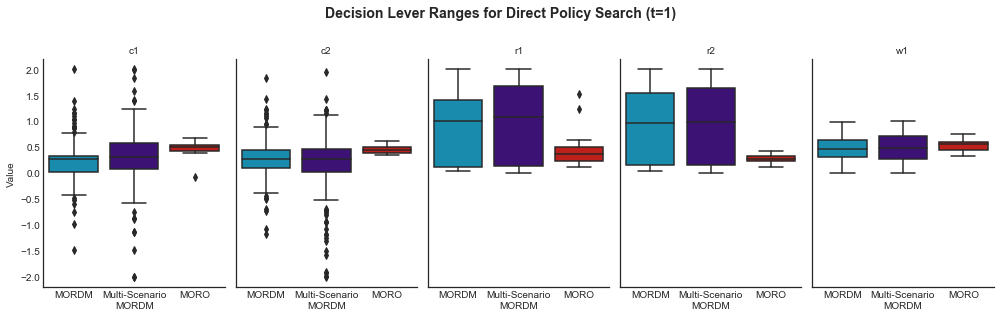

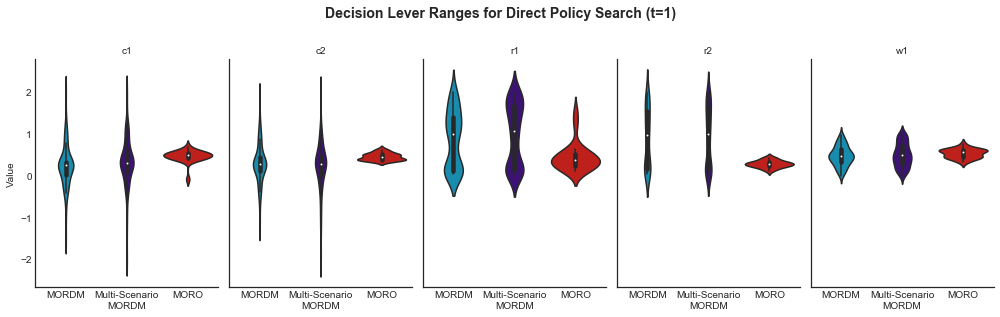

In [59]:
key = 'dps'
showLeverRanges(model=key, nondominated={'mordm': data['mordm']['nondominated'][key],
                                         'multi': data['multi']['nondominated'][key], 
                                         'moro': data['moro']['nondominated'][key]})

### Planned Adaptive DPS, t=10

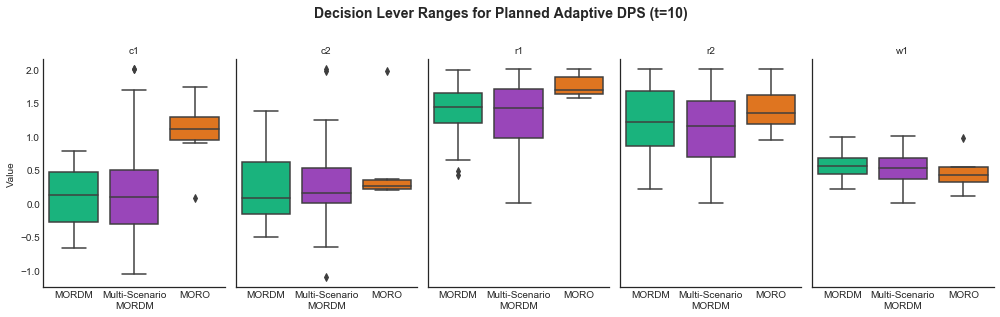

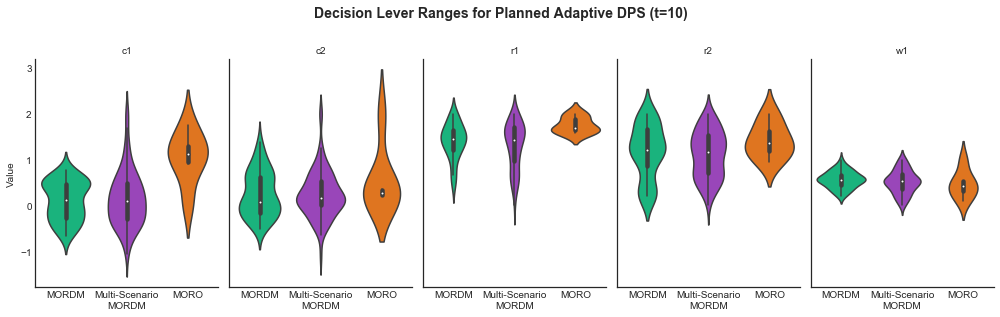

In [58]:
key = 'plannedadaptive'
showLeverRanges(model=key, nondominated={'mordm': data['mordm']['nondominated'][key],
                                         'multi': data['multi']['nondominated'][key], 
                                         'moro': data['moro']['nondominated'][key]})

# Comparing Lever Values

In [31]:
linewidth=0.5
def compareParetoLevers(model='', mordm=None, multi=None, moro=None):
    leverNames = getLeverNames(models[model])
    levers_mordm = mordm.loc[:, leverNames]
    levers_multi = multi.loc[:, leverNames]
    levers_moro = moro.loc[:, leverNames]
    
    limits = parcoords.get_limits(levers_mordm)
    limits.iloc[0, :] = 0
    limits.iloc[1, :] = 2
    limits.iloc[0, 0:2] = -2
    limits.iloc[1,4] = 1

    axes = parcoords.ParallelAxes(limits, rot=0, fontsize=14)
    axes.plot(levers_multi, color=primaryColors[model]['multi'], label=methodTitle['multi'], linewidth=linewidth)
    axes.plot(levers_mordm, color=primaryColors[model]['mordm'], label=methodTitle['mordm'], linewidth=linewidth)
    axes.plot(levers_moro, color=primaryColors[model]['moro'], label=methodTitle['moro'], linewidth=linewidth)
    axes.legend()
    axes.fig.suptitle(modelTitle[model].replace('\n','') + ' Comparison', fontsize=16, y = 1.05)

    plt.show()

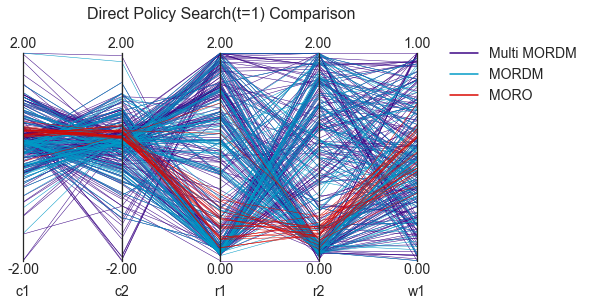

In [32]:
# All DPS
key = 'dps'
compareParetoLevers(model=key, mordm=data['mordm']['nondominated'][key][0],
                          multi=pd.concat(data['multi']['nondominated'][key]),
                          moro=data['moro']['nondominated'][key][0])

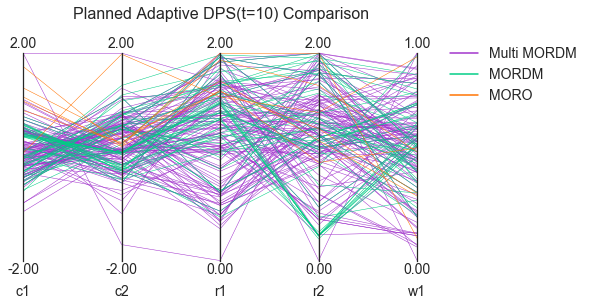

In [34]:
# All Adaptive Direct
key = 'plannedadaptive'
compareParetoLevers(model=key, mordm=data['mordm']['nondominated'][key][0],
                          multi=pd.concat(data['multi']['nondominated'][key]),
                          moro=data['moro']['nondominated'][key][0])

# Mapping Trend of Release Rules

In [13]:
def get_antropogenic_release(xt, c1, c2, r1, r2, w1):
    rule = w1*(abs(xt-c1)/r1)**3+(1-w1)*(abs(xt-c2)/r2)**3
    at1 = max(rule, 0.01)
    at = min(at1, 0.1)
    return at

def mapReleaseTrends(model='', releases={}):
    fig, axarr = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(7.5, 2))
    plotTitles = titles('method')
    for methodIdx, method in enumerate(order('method')): 
        if not method in releases: 
            continue
        for i, row in enumerate([item for sublist in releases[method] for item in sublist]): 
            if i == 0: 
                axarr[methodIdx].plot(list(range(100)), row, color=primaryColors[model][method], linewidth=1.0, label=plotTitles[methodIdx])
            axarr[methodIdx].plot(list(range(100)), row, color=primaryColors[model][method], linewidth=0.5)
        axarr[methodIdx].margins(0)
        axarr[methodIdx].set_xlim(0,100)
        axarr[methodIdx].set_ylim(0,0.11)
        if methodIdx == 2: 
            axarr[methodIdx].set_xlabel('Time Step', fontsize=10)
        if methodIdx == 1: 
            axarr[methodIdx].set_ylabel('Anthro. Pollution Release',fontsize=10)
            
        axarr[methodIdx].text(101, 0.05, plotTitles[methodIdx],  ha='left', va='center')

#     fig.subplots_adjust(hspace=0)
    fig.suptitle('Pollution Release Decisions over Time, ' + modelTitle[model].replace('\n',' '), fontsize=12, weight='bold', y=0.99)
    
    save_fig(fig, 'images/levers/', 'overtime_' + model)
    
    plt.show()

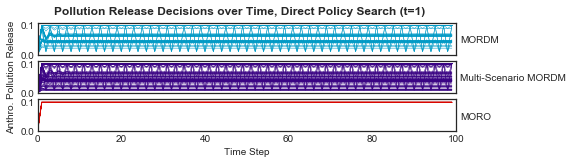

In [14]:
model = 'dps'
releases = {}
for method in data.keys(): 
    nondomianted = data[method]['nondominated'][model]
    cumReleaseLists = []
    for nond in nondomianted: 
        releaseList = []
        for idx, row in nond.iterrows(): 
            x = np.zeros(100)
            for i in range(1,100): 
                x[i] = get_antropogenic_release(x[i-1], row['c1'], row['c2'], row['r1'], row['r2'], row['w1'])
            releaseList.append(x)
    
        cumReleaseLists.append(releaseList)
    releases[method] = cumReleaseLists
    
mapReleaseTrends(model=model, releases=releases)

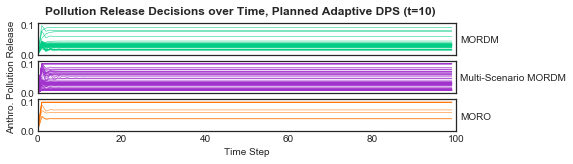

In [15]:
model = 'plannedadaptive'
releases = {}
for method in data.keys(): 
    nondomianted = data[method]['nondominated'][model]
    cumReleaseLists = []
    for nond in nondomianted: 
        releaseList = []
        for idx, row in nond.iterrows(): 
            x = np.zeros(100)
            for i in range(1,100): 
                x[i] = get_antropogenic_release(x[i-1], row['c1'], row['c2'], row['r1'], row['r2'], row['w1'])
            releaseList.append(x)
    
        cumReleaseLists.append(releaseList)
    releases[method] = cumReleaseLists
    
mapReleaseTrends(model=model, releases=releases)

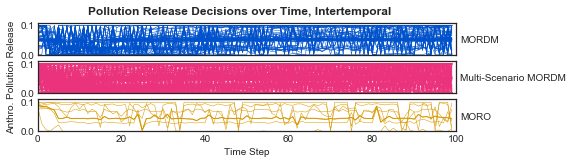

In [16]:
model = 'intertemporal'
releases = {}
for method in data.keys(): 
    leverNames = getLeverNames(models[model])
    
    nondomianted = data[method]['nondominated'][model]
    cumReleaseLists = []
    for nond in nondomianted: 
        releaseList = []
        for idx, row in nond[leverNames].iterrows(): 
            releaseList.append(list(row))
    
        cumReleaseLists.append(releaseList)
    releases[method] = cumReleaseLists

mapReleaseTrends(model=model, releases=releases)

## Release Rules

In [75]:
n = 2
q = 2
b = 0.42
def fun(x):
    return [(x[0]**q)/(1+x[0]**q) - b*x[0]]
soln = root(fun, 0.75)
pCrit = soln.x

lake_state = np.arange(0.0,1.01,0.01)
def buildRuleData(levers): 
    releaseList = []
    for idx, policy in levers.iterrows(): 
        Y = np.zeros([len(lake_state)])
        for j in range(len(lake_state)):
            Y[j] = get_antropogenic_release([lake_state[j]], policy['c1'],policy['c2'],policy['r1'],policy['r2'],policy['w1']) # best reliability
            
        releaseList.append(Y)
    return releaseList

def mapReleaseRules(model, releases):
    fig, axarr = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(7.5,2.5))
    plotTitles = titles('method')

    for idx, method in enumerate(order('method')): 
        for refIdx, releaseList in enumerate(releases[method]): 
            for Y in releaseList: 
                color = primaryColors[model][method] if method != 'multi' else fullColors[model][method][refIdx]
                axarr[idx].plot(lake_state,Y,c=color, linewidth=0.3)
        axarr[idx].plot([pCrit, pCrit],[0.0,0.12],c='black', linewidth=2)
    
        if idx == 1: 
            axarr[idx].set_xlabel('Lake Pollution Concentration',fontsize=10)
        if idx == 0: 
            axarr[idx].set_ylabel('Anthro. Pollution Release',fontsize=10)
        axarr[idx].set_title(plotTitles[idx], fontsize=10)
        axarr[idx].set_xlim(0,1)
        axarr[idx].set_ylim(0,0.12)
        axarr[idx].tick_params(axis='both',labelsize=8)
    
    plt.suptitle('Recommended Anthropogenic Release Rules, ' + modelTitle[model].replace('\n',' '), fontsize=12, weight='bold', y=1.05)
    plt.tight_layout()
    
    save_fig(fig, 'images/levers/', 'rules_' + model)
    
    plt.show()


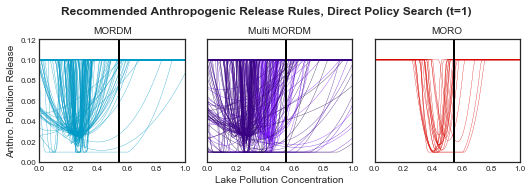

In [76]:
model = 'dps'
releases = {}
for method in data.keys(): 
    nondomianted = data[method]['nondominated'][model]
    cumReleaseLists = []
    for nond in nondomianted: 
        releaseList = buildRuleData(levers=nond[getLeverNames(models[model])])
        cumReleaseLists.append(releaseList)
    releases[method] = cumReleaseLists
mapReleaseRules(model=model, releases=releases)

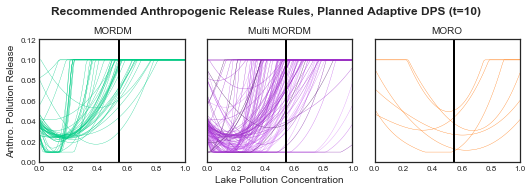

In [77]:
model = 'plannedadaptive'
releases = {}
for method in data.keys(): 
    nondomianted = data[method]['nondominated'][model]
    cumReleaseLists = []
    for nond in nondomianted: 
        releaseList = buildRuleData(levers=nond[getLeverNames(models[model])])
        cumReleaseLists.append(releaseList)
    releases[method] = cumReleaseLists
mapReleaseRules(model=model, releases=releases)